In [1]:
import wandb
wandb.login()

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

import params
import pickle
import joblib

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: arihantsheth (tri-nit). Use `wandb login --relogin` to force relogin


In [2]:
def get_df_wandb(name):
    data_artifact = wandb.use_artifact(f"{params.DATA_ART}:latest")
    table = data_artifact.get(f"{name}_data_table")
    df = pd.DataFrame(data=table.data, columns=table.columns)

    return df


def encode_crop(df_crop):
    label_encoder = LabelEncoder()

    encoded_crop = label_encoder.fit_transform(df_crop["label"])

    dict_crop = {}
    for i in range(len(encoded_crop)):
        dict_crop[df_crop.loc[i, "label"]] = encoded_crop[i]

    df_crop["label"] = df_crop["label"].map(dict_crop)

    return df_crop, dict_crop


def decode_crop(dict_crop, val):
    for key, value in dict_crop.items():
        if value == val:
            return key


def split_data(x, y, test_size=0.2, random_state=42):
    x_train, x_test, y_train, y_test = train_test_split(x,
                                                        y,
                                                        test_size=test_size,
                                                        random_state=random_state)

    y_train = np.reshape(y_train, (-1,))
    y_test = np.reshape(y_test, (-1,))

    return x_train, x_test, y_train, y_test


def standardize(x, type):
    scaler = StandardScaler().fit(x)
    x_scaled = scaler.transform(x)

    joblib.dump(scaler, f"../scalers/{type}_scaler.gz")

    return x_scaled


def save_model(model, name):

    with open(f"../models/{name}_model.pkl", "wb") as f:
        pickle.dump(model, f)


def upload_model(name):
    model_artifact = wandb.Artifact(name, type="model")
    model_artifact.add_file(f"../models/{name}_model.pkl")
    wandb.log_artifact(model_artifact)

In [3]:
wandb.init(project=params.PROJECT, entity=params.ENTITY, job_type="baseline_model", name="random_forest_model_delete_me")

df_crop = get_df_wandb("crop")
df_crop, dict_crop = encode_crop(df_crop)

x = np.array(df_crop.iloc[:, :-1].copy())
y = np.array(df_crop.iloc[:, -1:].copy())

x_scaled = standardize(x, "all")

x_train, x_test, y_train, y_test = split_data(x_scaled, y, test_size=0.2, random_state=42)

# wandb.finish()

wandb:   2 of 2 files downloaded.  


In [4]:
labels = [x for x in dict(sorted(dict_crop.items(), key= lambda x: x[1])).keys()]

# Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression

# wandb.init(project=params.PROJECT, entity=params.ENTITY, job_type="train_model", name="logistic_regression_model")

logistic_regression = LogisticRegression(max_iter=1000)
logistic_regression.fit(x_train, y_train)

y_pred = logistic_regression.predict(x_test)
y_probas = logistic_regression.predict_proba(x_test)

y_pred_train = logistic_regression.predict(x_train)
train_accuracy = accuracy_score(y_train, y_pred_train)

test_accuracy = accuracy_score(y_test, y_pred)
labels = [x for x in dict(sorted(dict_crop.items(), key= lambda x: x[1])).keys()]

print(f"Accuracy of Logistic Regression: {test_accuracy}")

wandb.log({
    "test_accuracy": test_accuracy,
    "train_accuracy": train_accuracy
})

wandb.sklearn.plot_classifier(logistic_regression,
                              x_train, 
                              x_test,
                              y_train,
                              y_test,
                              y_pred,
                              y_probas,
                              labels,
                              is_binary=False,
                              model_name="LogisticRegression"
)

save_model(logistic_regression, "logistic_regression")
upload_model("logistic_regression")

wandb.finish()

wandb: 
wandb: Plotting LogisticRegression.
wandb: WARNING 2-dimensional feature importances array passed to plot_feature_importances. 2-dimensional and higher feature importances arrays are not currently supported. These importances will not be plotted.
wandb: Logged feature importances.


Accuracy of Logistic Regression: 0.9636363636363636


wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: WARNING This function only supports binary classification at the moment and therefore expects labels to be binary. Skipping calibration curve.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_accuracy,▁
train_accuracy,▁
test_accuracy,0.96364
train_accuracy,0.97784


# Decision Tree

In [28]:
from sklearn.tree import DecisionTreeClassifier

# wandb.init(project=params.PROJECT, entity=params.ENTITY, job_type="train_model", name="decision_tree_model")

decision_tree = DecisionTreeClassifier()
decision_tree.fit(x_train, y_train)

y_pred = decision_tree.predict(x_test)
y_probas = decision_tree.predict_proba(x_test)

y_pred_train = decision_tree.predict(x_train)

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy of Decision Tree: {test_accuracy}")

wandb.log({
    "test_accuracy": test_accuracy,
    "train_accuracy": train_accuracy
})

wandb.sklearn.plot_classifier(decision_tree,
                              x_train, 
                              x_test,
                              y_train,
                              y_test,
                              y_pred,
                              y_probas,
                              labels,
                              is_binary=False,
                              model_name="DecisionTreeClassifier"
)

save_model(decision_tree, "decision_tree")
upload_model("decision_tree")

wandb.finish()

wandb: 
wandb: Plotting DecisionTreeClassifier.


Accuracy of Decision Tree: 0.9840909090909091


wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: WARNING This function only supports binary classification at the moment and therefore expects labels to be binary. Skipping calibration curve.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


test_accuracy,▁
train_accuracy,▁
test_accuracy,0.98409
train_accuracy,1.0


## Plot Decision Tree

In [34]:
decision_tree.get_depth()

13

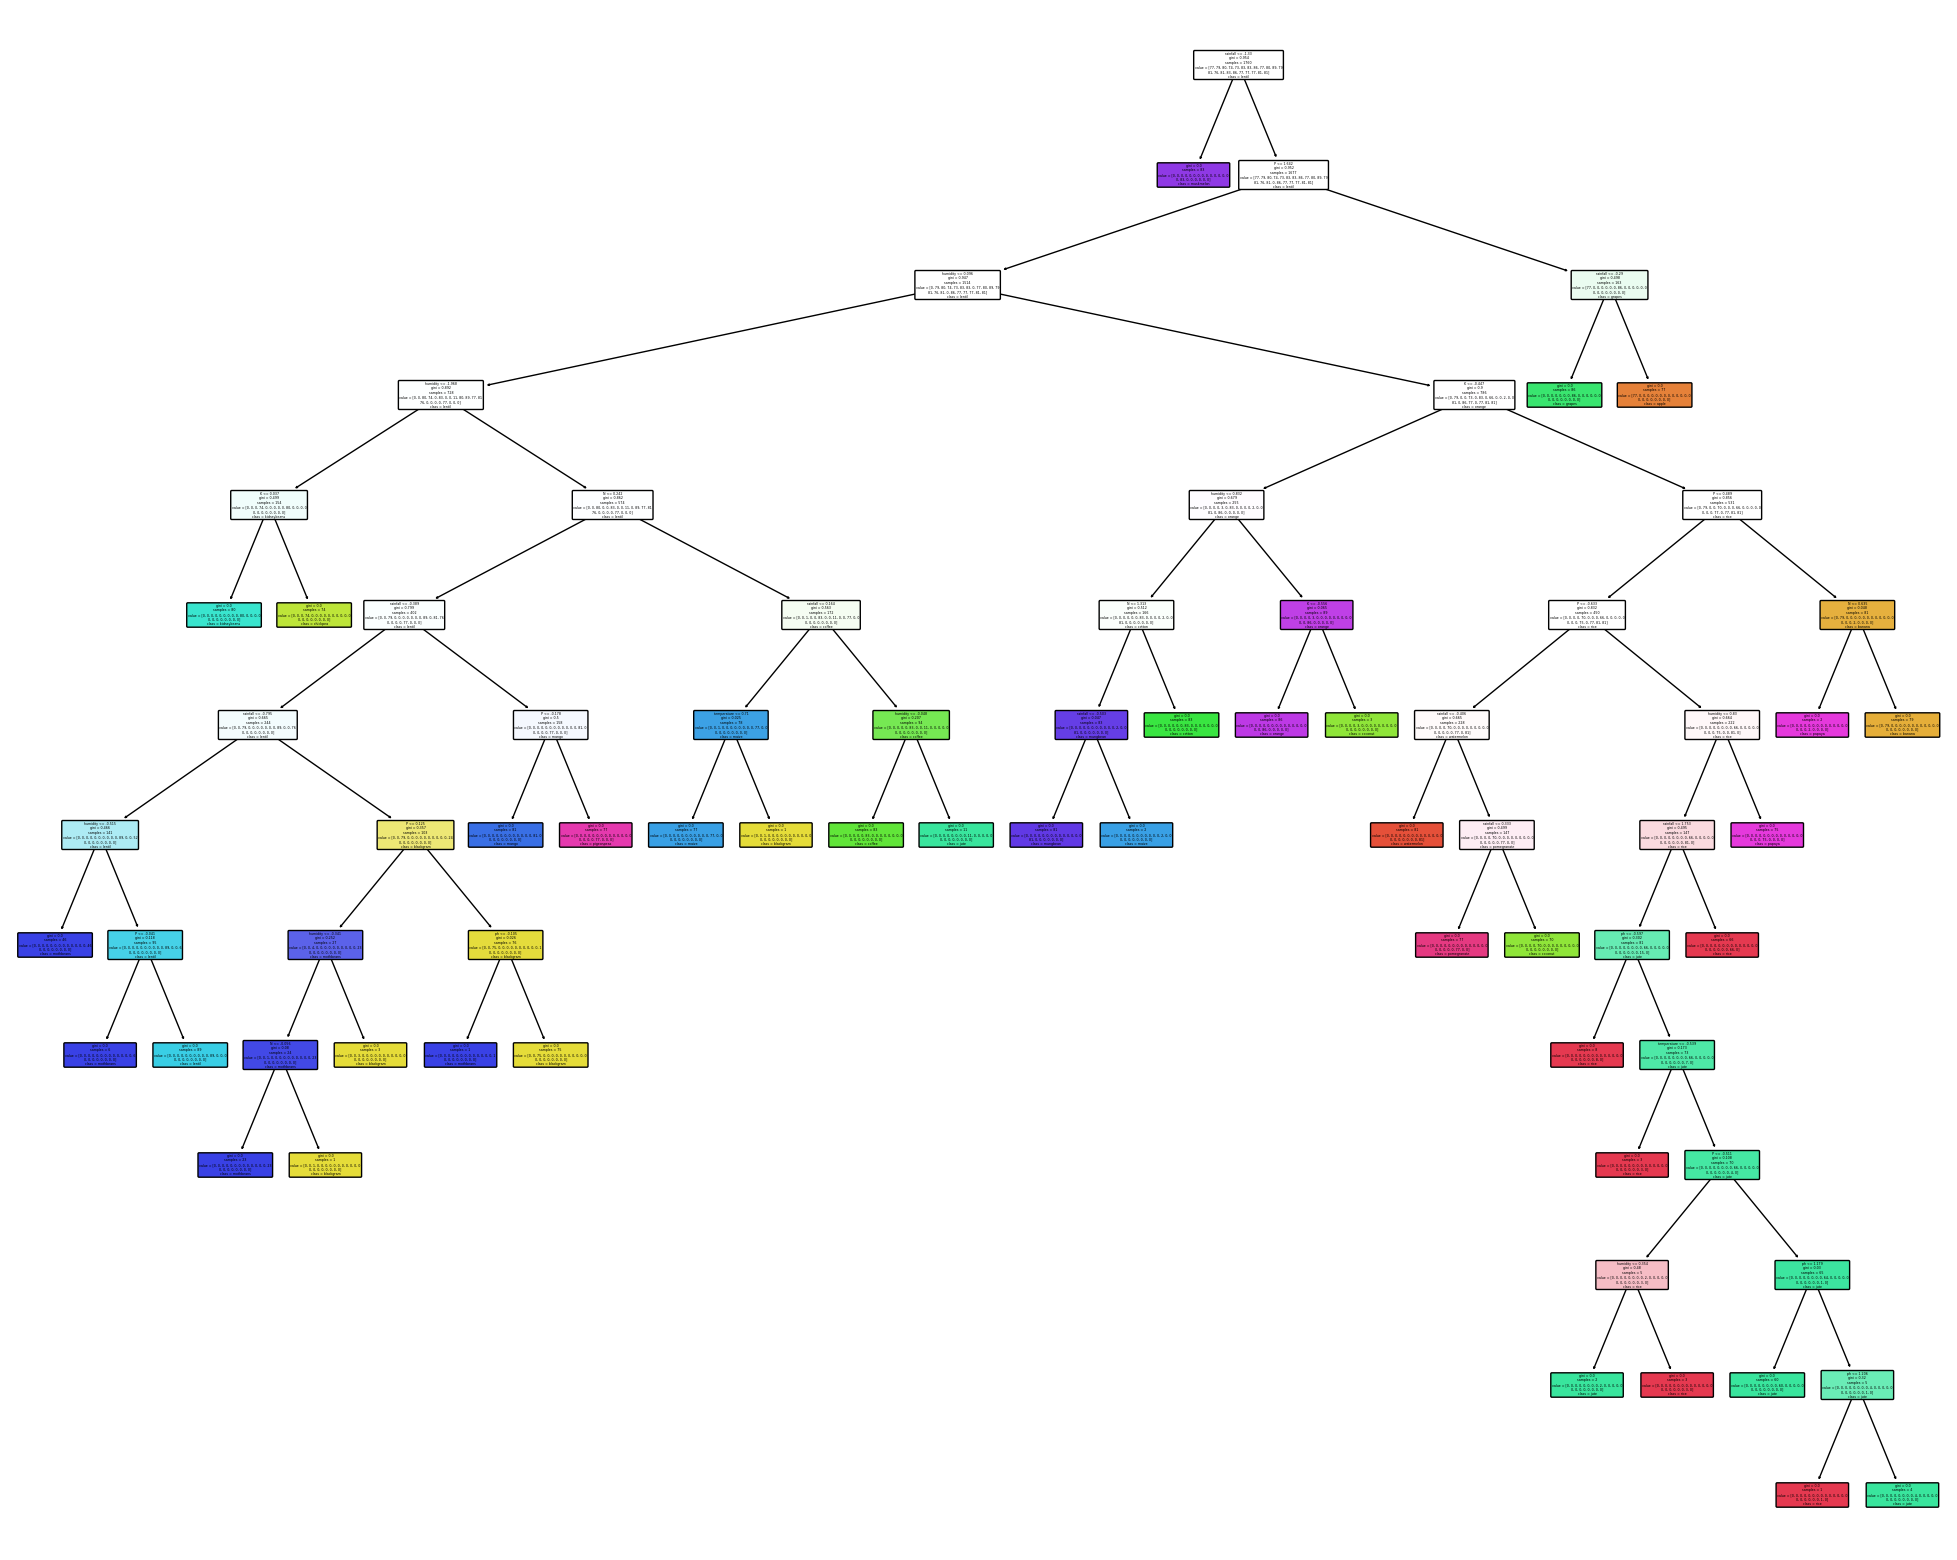

In [35]:
import matplotlib.pyplot as plt
# from dtreeviz.trees import dtreeviz
from sklearn.tree import plot_tree

# plot tree for the above model
plt.figure(figsize=(25, 20))
plot_tree(decision_tree, filled=True, rounded=True, feature_names=df_crop.columns[:-1], class_names=labels)
# save the tree
plt.savefig("decision_tree.png", dpi=600)
plt.show()

# Random Forest

In [5]:
from sklearn.ensemble import RandomForestClassifier

# wandb.init(project=params.PROJECT, entity=params.ENTITY, job_type="train_model", name="random_forest_model")

random_forest = RandomForestClassifier(n_estimators=4,
                                       max_depth=7,
                                       )
random_forest.fit(x_train, y_train)

y_pred = random_forest.predict(x_test)
y_probas = random_forest.predict_proba(x_test)

y_pred_train = random_forest.predict(x_train)

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy of Random Forest: {test_accuracy}")

# wandb.log({
#     "test_accuracy": test_accuracy,
#     "train_accuracy": train_accuracy
# })

# wandb.sklearn.plot_classifier(random_forest,
#                               x_train, 
#                               x_test,
#                               y_train,
#                               y_test,
#                               y_pred,
#                               y_probas,
#                               labels,
#                               is_binary=False,
#                               model_name="RandomForestClassifier"
# )

# save_model(random_forest, "random_forest")
# upload_model("random_forest")

# wandb.finish()

Accuracy of Random Forest: 0.9681818181818181


## plot_tree sklearn

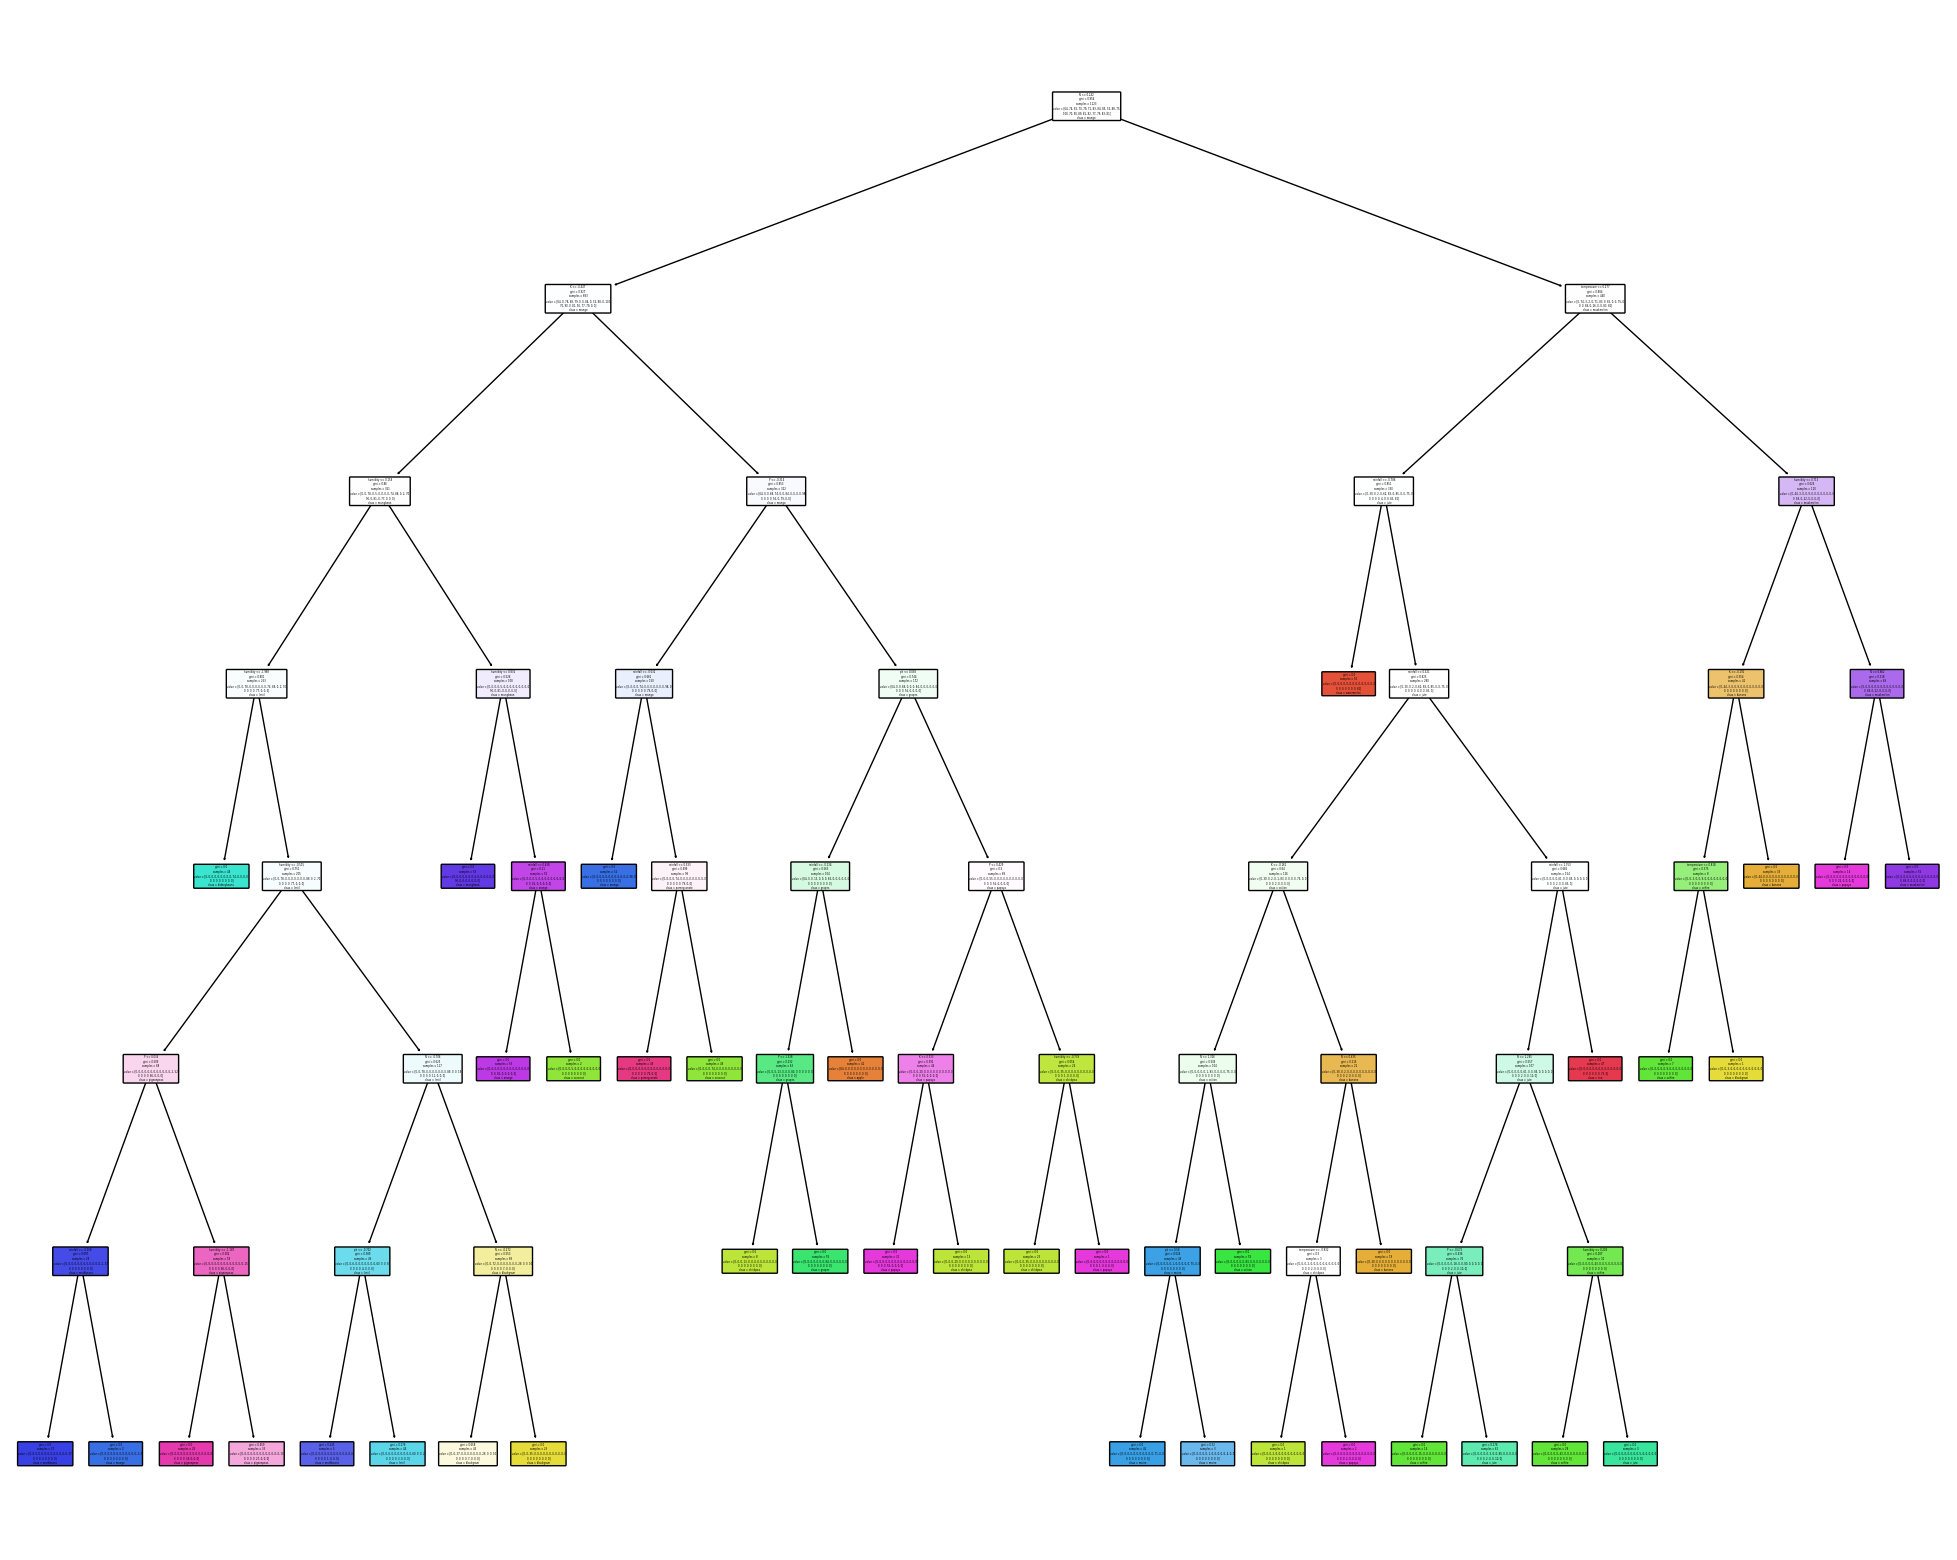

In [52]:
plt.figure(figsize=(25, 20))
plot_tree(random_forest.estimators_[0], filled=True, rounded=True, feature_names=df_crop.columns[:-1], class_names=labels)
plt.savefig("random_forest_0.png", dpi=600)
plt.show()

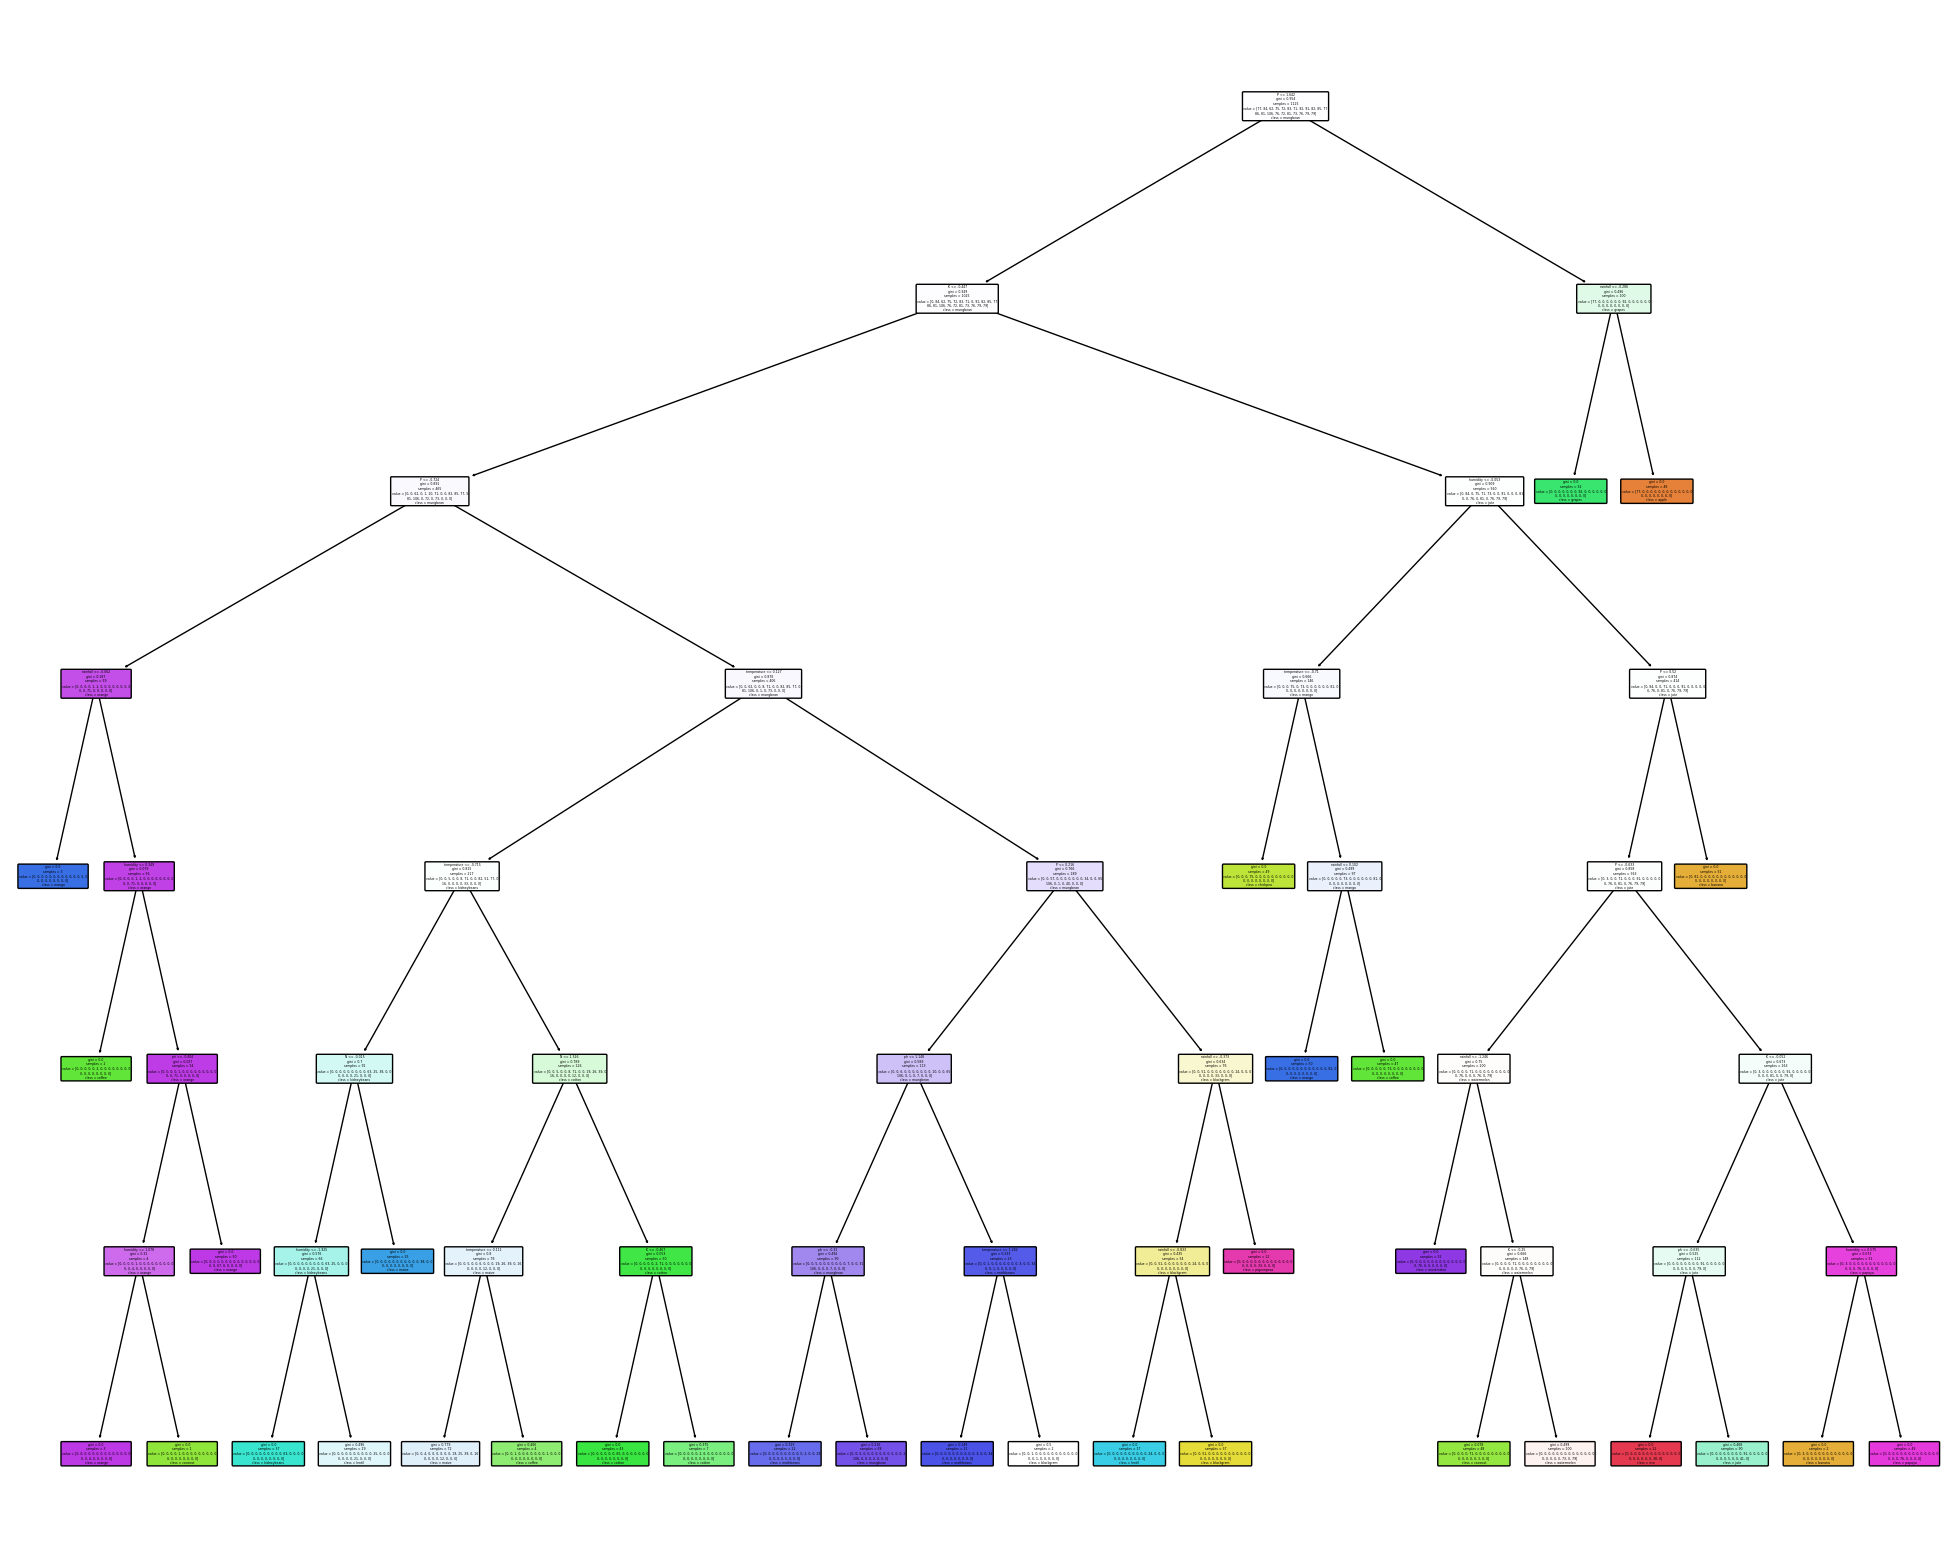

In [53]:
plt.figure(figsize=(25, 20))
plot_tree(random_forest.estimators_[1], filled=True, rounded=True, feature_names=df_crop.columns[:-1], class_names=labels)
plt.savefig("random_forest_1.png", dpi=600)
plt.show()

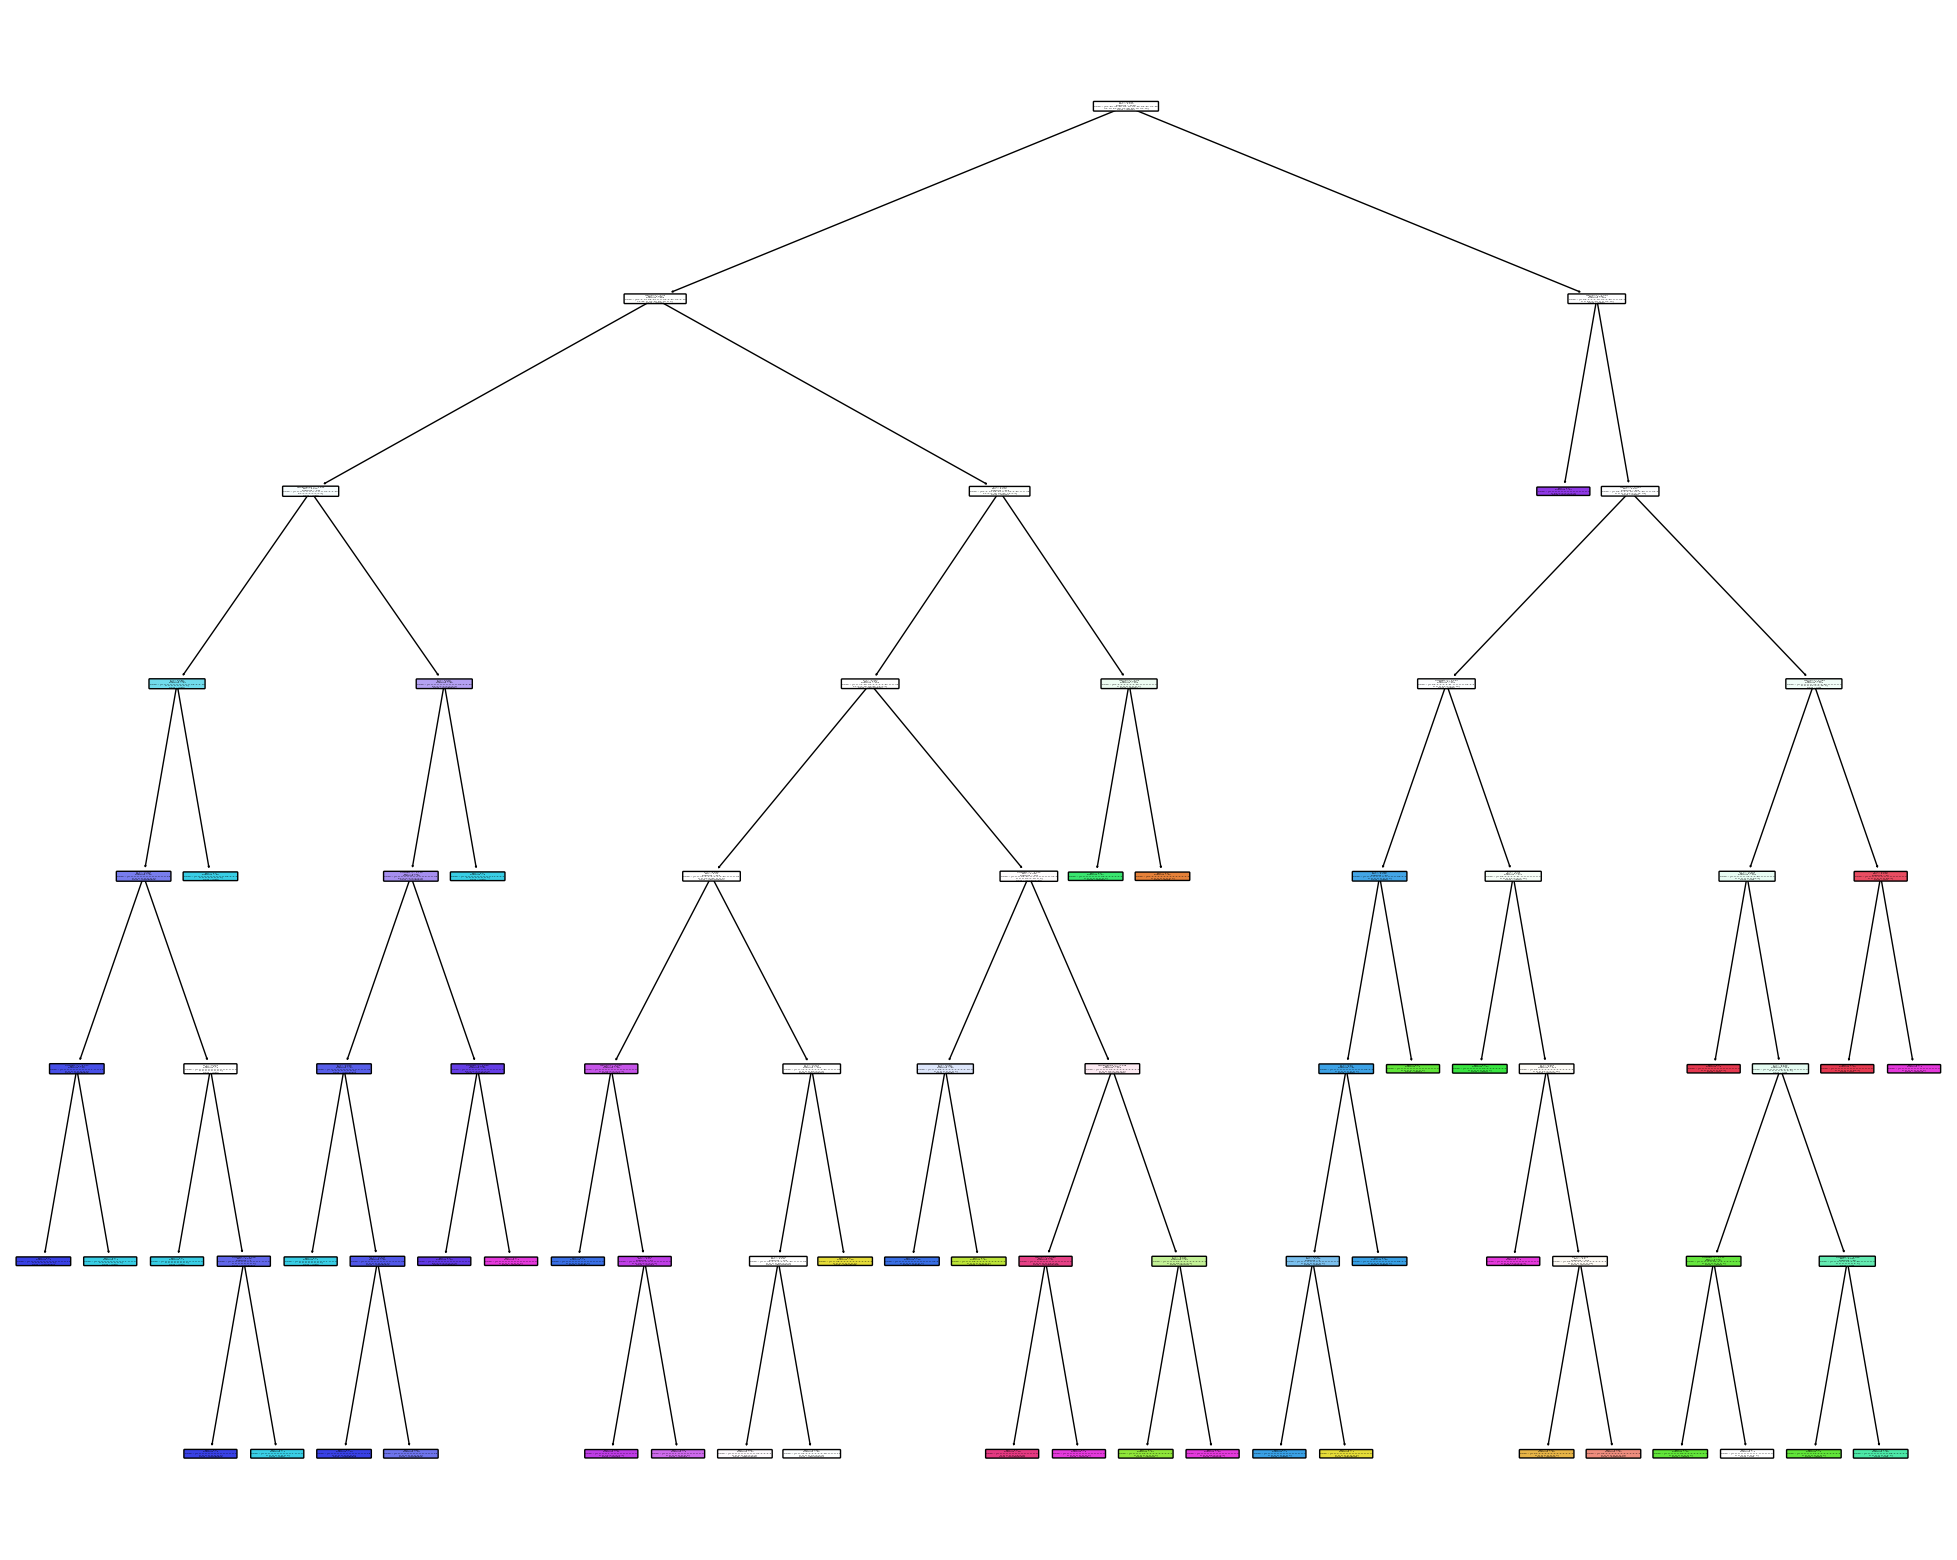

In [54]:
plt.figure(figsize=(25, 20))
plot_tree(random_forest.estimators_[2], filled=True, rounded=True, feature_names=df_crop.columns[:-1], class_names=labels)
plt.savefig("random_forest_2.png", dpi=600)
plt.show()

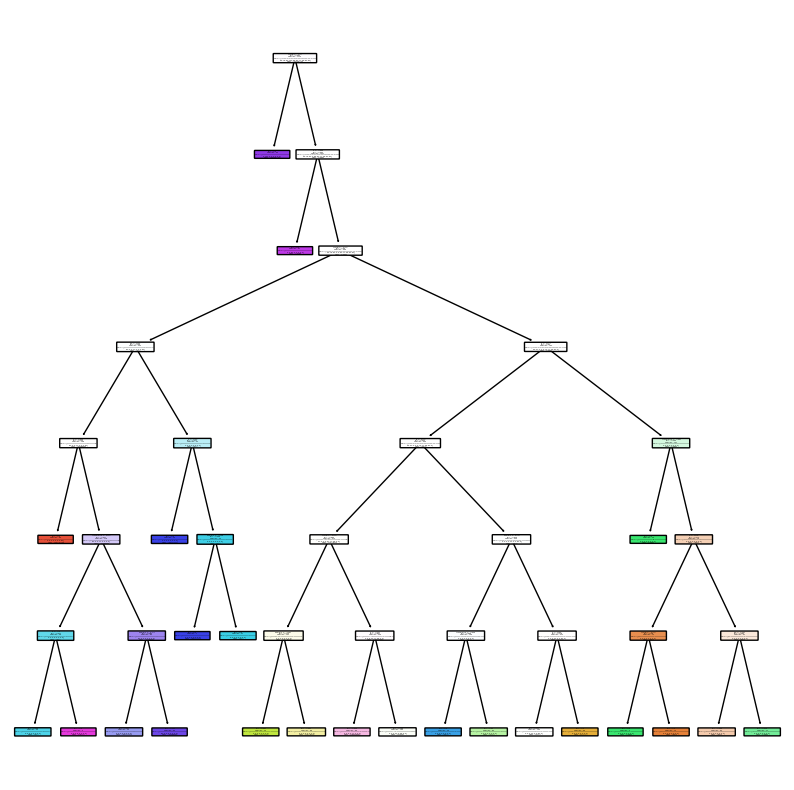

In [57]:
plt.figure(figsize=(10, 10))
plot_tree(random_forest.estimators_[3], filled=True, rounded=True, feature_names=df_crop.columns[:-1], class_names=labels)
plt.savefig("random_forest_3.png", dpi=600)
plt.show()

# Using dtreeviz

In [6]:
# plot tree using dtreeviz
import dtreeviz
viz = dtreeviz.model(random_forest.estimators_[0],
                           x_train,
                           y_train,
                           target_name="crop",
                           feature_names=df_crop.columns[:-1],
                           class_names=labels
                           )

viz.view()

ExecutableNotFound: failed to execute 'dot', make sure the Graphviz executables are on your systems' PATH

In [66]:
decision_tree.predict_proba(x_test[0].reshape(1, -1))

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0.]])

In [74]:
sorted(random_forest.predict_proba(x_test[1].reshape(1, -1))[0], reverse=True)

0.8155777748827515

In [82]:
tmp_arr = random_forest.predict_proba(x_test[1].reshape(1, -1))[0]

# get the index of the top 3 probabilities
top_3 = sorted(range(len(tmp_arr)), key=lambda i: tmp_arr[i])[-3:]

for i in top_3:
    print(decode_crop(dict_crop, i))

banana
pomegranate
watermelon


In [78]:
top_3

[1, 19, 21]